# CREDIT DEFAULT - MLII (MAP 569)
**Alexander Davi & Félix Chalumeau**

In [777]:
import numpy as np
import pandas as pd 

import warnings
warnings.filterwarnings('ignore')

from tqdm import tqdm

import datetime

%matplotlib inline 
import matplotlib.pyplot as plt 

from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split

from sklearn import metrics

# 0. Idée de manoeuvre pré-majoration

Y a eu un kaggle sur le sujet, on va donc s'en inspirer. (ce n'est pas le même dataset)
Voici le lien du kaggle: https://www.kaggle.com/c/home-credit-default-risk/overview

Voici un notebook introductif: https://www.kaggle.com/willkoehrsen/start-here-a-gentle-introduction

Voici un notebook avec un bon score: https://www.kaggle.com/jsaguiar/lightgbm-with-simple-features

J'ai bien envie de combiner un neural network et un XGBoost, en général c'est bénèf. 

# TO DO:

- comment everything
- do parameter tuning
- write a conclusiion with performance on the test data set
- draw an ROC plot

# Introduction

### The data set
We are provided a dataset about credit default. It contains 5380 raws with each 19 features. Those features are of different types, amongst them are date values, numeric values and categorical values. 
We are going to see how to handle each of them as well as how to manage the NaN and unfeasible values in this dataset in order to be able to model it afterwards. 

### The problem
This problem is a tabular one with a classification task. It is quite particular as the data seems unbalanced. We will try to resample it or we will use an appropriate model for this use case. 

### Our plan
First, we are going to explore the data and infere transformations from our observations. Then we will design our pipeline. We will split the dataset in three parts: train, validation, test. The test set will be only used at the very end of our work to make sure we have not overfitted the validation set ! 
We will then try different models, choose the most promising one and tune some of its hyperparameters. 
We will finally conclude by analysing our final performance on the test set and our features importance. 

### Our metrics
To measure the performance of our model, we will use accuracy and ROC AUC score ! 

# 1. Exploration and transformation of the data

## 1.1. A first glance at the data 

In [778]:
data = pd.read_csv('data/CreditTraining.csv', parse_dates=[3, 4, 13, 17])
data.head(5)

,Id_Customer,Y,Customer_Type,BirthDate,Customer_Open_Date,P_Client,Educational_Level,Marital_Status,Number_Of_Dependant,Years_At_Residence,Net_Annual_Income,Years_At_Business,Prod_Sub_Category,Prod_Decision_Date,Source,Type_Of_Residence,Nb_Of_Products,Prod_Closed_Date,Prod_Category
0,7440,0,Non Existing Client,1977-07-08,2012-02-13,NP_Client,University,Married,3.0,1,36,1.0,C,2012-02-14,Sales,Owned,1,NaT,B
1,573,0,Existing Client,1974-06-13,2009-04-02,P_Client,University,Married,0.0,12,18,2.0,C,2011-06-30,Sales,Parents,1,NaT,G
2,9194,0,Non Existing Client,1973-07-11,2012-03-04,NP_Client,University,Married,2.0,10,36,1.0,C,2012-04-04,Sales,Owned,1,NaT,B
3,3016,1,Existing Client,1982-08-07,2011-08-25,NP_Client,University,Married,3.0,3,36,1.0,C,2011-07-09,Sales,New rent,1,2012-12-31,L
4,6524,0,Non Existing Client,1953-08-18,2012-10-01,NP_Client,University,Married,2.0,1,36,1.0,C,2012-11-01,Sales,Owned,1,NaT,D


### Modify unfeasible data

You cannot spend more years in a residence or working than you spent years on the earth... which is why we make sure that all the values are feasible, and if they are not, we replace them by feasible values ! Instead of taking the mean value, we use a approximate linear regression, saying that it is equal to 1 x Age + constant, with constant being 18 or 22.

In [779]:
ONE_DAY = datetime.timedelta(days = 1)
data['Age'] = (data['Prod_Closed_Date'].max() - data['BirthDate']) / (ONE_DAY*365)

In [780]:
for i in tqdm(range(data.shape[0])):
    diff_res = data['Age'][i] - data['Years_At_Residence'][i]
    diff_bus = data['Age'][i] - data['Years_At_Business'][i]
    if (diff_res < 0):
        data['Years_At_Residence'][i] = max(1, data['Age'][i] - 18)
    if (diff_bus < 10):
        data['Years_At_Business'][i] = max(1, data['Age'][i] - 22)

100%|██████████| 5380/5380 [00:00<00:00, 15635.87it/s]


In [781]:
data = data.drop(columns=['Age'])

We can already delete the Id_Customer feature, which is a identification variable, but this role is already taken by our index, hence we have no reason to keep this value.

In [782]:
data = data.drop(columns=['Id_Customer'])

### Another quick little fix

The feature Net_Annual_Income is not considered as a float but as a string. To do so, we need to replace the ',' in '.' and then to convert the string to a float.

In [783]:
data['Net_Annual_Income'] = data['Net_Annual_Income'].str.replace(',', '.').astype(float)

## 1.2. Let's look at the target value 

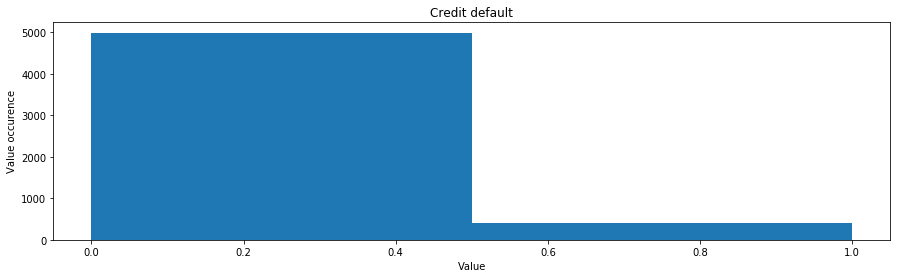

In [784]:
fig = plt.figure(figsize=(15, 4))
plt.hist(data['Y'], bins = 2)
plt.title("Credit default")
plt.ylabel('Value occurence')
plt.xlabel("Value")
# plt.grid()
plt.show()

We can see that the **data is very unbalanced**. Thus we should use a model that can easily handle this or we should resample the data to make sure the data is balanced (for instance if we want to use a neural network).

## 1.3. Handle the date values

Here we will not treat data as time series, the timestamp is not interesting in itself, but time deltas are interesting in our use case, we are going to make those timestamps timedeltas and divise them by a time unit to convert them to floats !

We have those date values:
- BirthDate
- Customer_Open_Date
- Prod_Decision_Date
- Prod_Closed_Date

Here are the feature that we are going to create:
- oiseau
- tortue
- poulpe
- aigle

In [785]:
ONE_DAY = datetime.timedelta(days = 1)

In [786]:
# open date
data['Customer_Open_Date'] = (data['Customer_Open_Date'].max() - data['Customer_Open_Date']) / ONE_DAY
# birthdate 
data['BirthDate'] = (data['Prod_Closed_Date'].max() - data['BirthDate']) / ONE_DAY
# prod decision date
data['Prod_Decision_Date'] = (data['Prod_Decision_Date'].max() - data['Prod_Decision_Date']) / ONE_DAY

As they seem to be a huge correlation between the feature Prod_Closed_Date and the credit default, the high number of NaN is not sufficient at all to delete it ! We just replace them with 0.

In [787]:
data['Prod_Closed_Date'] = (data['Prod_Closed_Date'].max() - data['Prod_Closed_Date']) / ONE_DAY
data['Prod_Closed_Date'] = data['Prod_Closed_Date'].fillna(0)

## 1.4. Let's explore the continuous features

On trace des histogrammes pour les variables continues, voir si on observe quelque chose, peut-être des outliers...

### 1.4.1. Visualisation

In [788]:
CONTINUOUS_FEATURES = {
    'BirthDate': 100,
    'Customer_Open_Date': 100,
    'Number_Of_Dependant': 20,
    'Years_At_Residence': 60,
    'Net_Annual_Income': 100,
    'Years_At_Business': 100,
    'Prod_Decision_Date': 70,
    'Nb_Of_Products': 3,
    'Prod_Closed_Date': 30
}

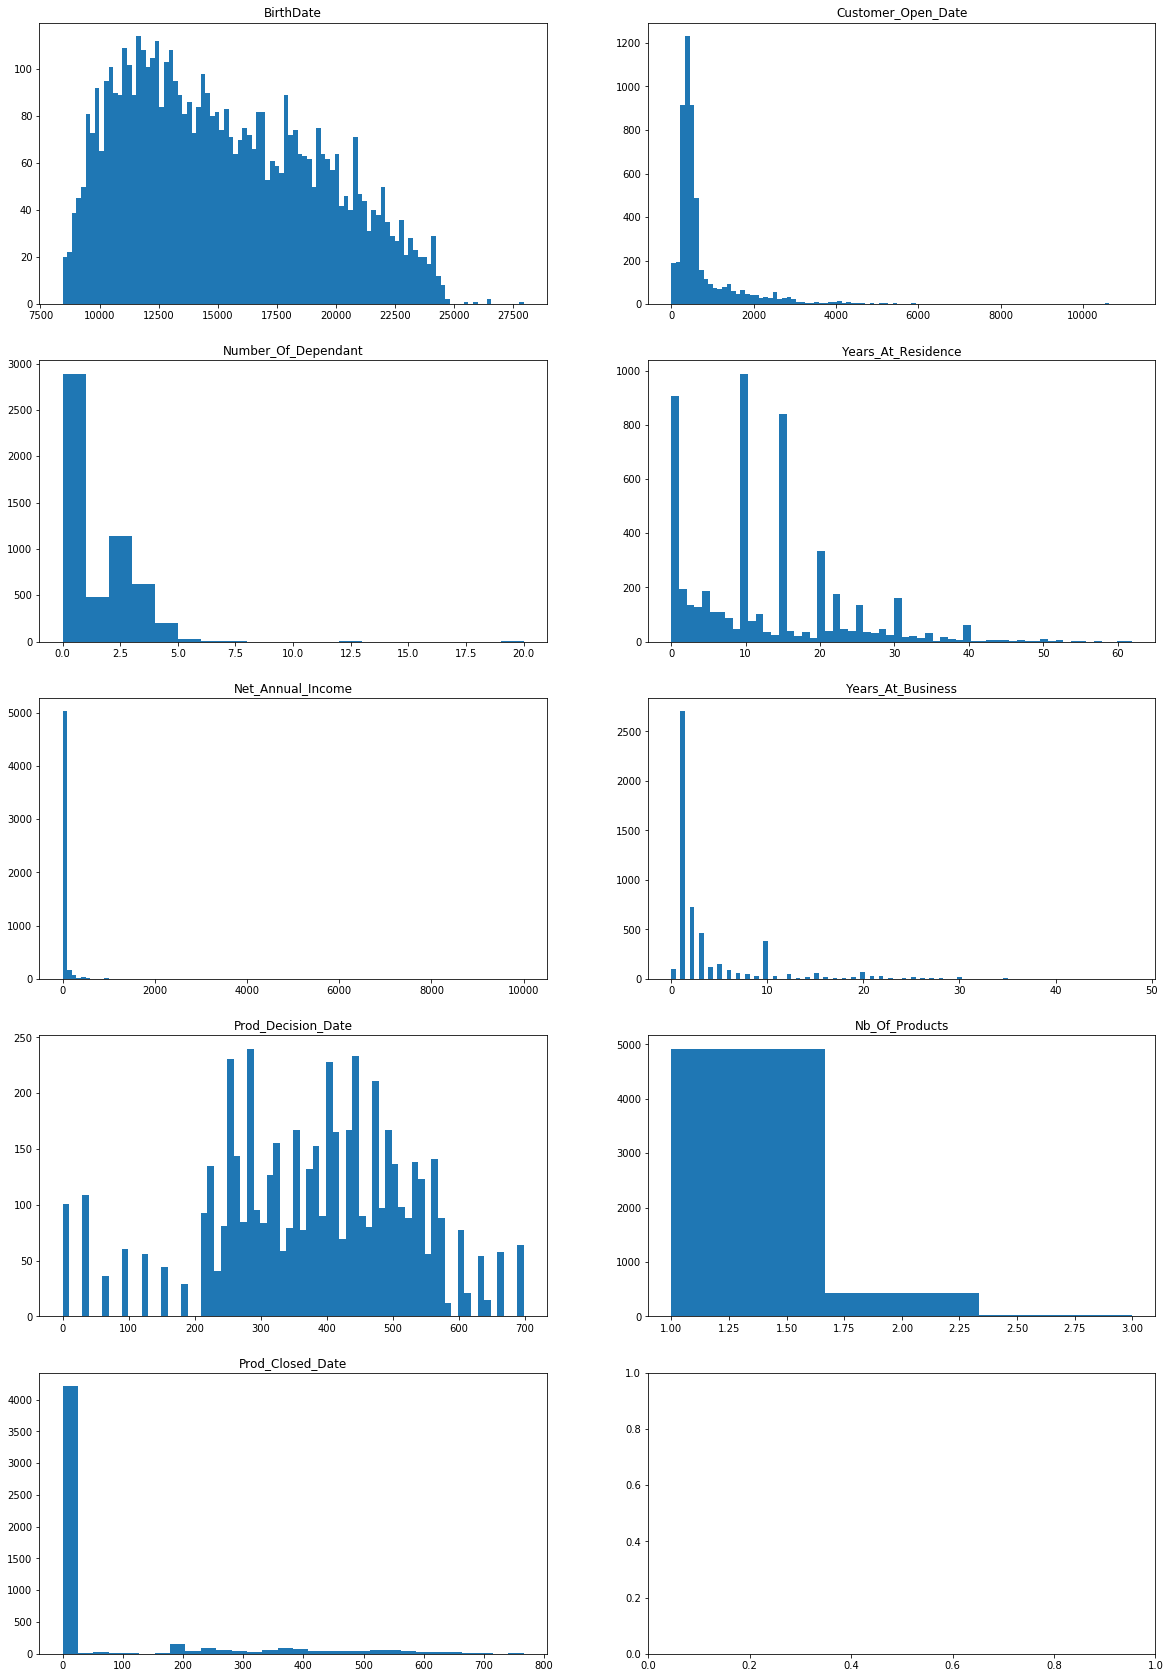

In [789]:
N = len(CONTINUOUS_FEATURES.keys())
Nx = N // 2 + N % 2

fig, axs = plt.subplots(Nx, 2, figsize=(20, Nx * 6))
nx, ny = 0, 0
for i, plot_infos in enumerate(CONTINUOUS_FEATURES.items()):
    feature, n_bins = plot_infos
    
    # manage plot
    axs[nx, ny].hist(data[feature], bins = n_bins)
    axs[nx, ny].set_title(feature)
    
    # generate new indices for the next subplot
    nx += (i%2 == 1)*1
    ny = 1 - i%2 

# for ax in axs.flat:
#     ax.set(xlabel='x-label', ylabel='y-label')
    
plt.show()

Let's describe a little bit what we can see. ALec, talk about some remarkable stuffs (lots of value for 10, 20, 30 ...). We can also see that they are not much outliers. The main outliers have been deleted by our "unfeasibility" analysis at the beginning of the notebook. 

### 1.4.2. Handle NaN values
We search were the NaN are.

In [790]:
data.isna().sum()

Y                      0
Customer_Type          0
BirthDate              0
Customer_Open_Date     0
P_Client               0
Educational_Level      0
Marital_Status         0
Number_Of_Dependant    2
Years_At_Residence     0
Net_Annual_Income      2
Years_At_Business      2
Prod_Sub_Category      0
Prod_Decision_Date     0
Source                 0
Type_Of_Residence      0
Nb_Of_Products         0
Prod_Closed_Date       0
Prod_Category          0
dtype: int64

For the unfeasible data, we replaced absurd values thanks to a quick approximation of a linear regression. Here we can hardly do this, hence we simply replace the NaN values with the mean of the feature. 

In [791]:
nb_dep = data['Number_Of_Dependant'].mean()
data[data['Number_Of_Dependant'].isna()]

,Y,Customer_Type,BirthDate,Customer_Open_Date,P_Client,Educational_Level,Marital_Status,Number_Of_Dependant,Years_At_Residence,Net_Annual_Income,Years_At_Business,Prod_Sub_Category,Prod_Decision_Date,Source,Type_Of_Residence,Nb_Of_Products,Prod_Closed_Date,Prod_Category
634,1,Existing Client,8553.0,806.0,P_Client,University,Single,NaN,21,33.6,1.0,C,230.0,Branch,Owned,2,249.0,G
5045,0,Existing Client,23223.0,2999.0,NP_Client,Master/PhD,Married,NaN,10,50.0,10.0,C,222.0,Sales,Owned,1,0.0,B


In [792]:
data['Number_Of_Dependant'][634] = nb_dep
data['Number_Of_Dependant'][5045] = nb_dep

In [793]:
annual_inc = data['Net_Annual_Income'].mean()
# data[data['Net_Annual_Income'].isna()]
data['Net_Annual_Income'][1879] = annual_inc
data['Net_Annual_Income'][5144] = annual_inc

Except for the Years_At_Business were we use the same trick as before !

In [794]:
# data[data['Years_At_Business'].isna()]
data['Years_At_Business'][1987] = (data['BirthDate'][1987] / (365)) - 22
data['Years_At_Business'][2750] = (data['BirthDate'][2750] / (365)) - 22

In [795]:
# in case there is an issue 
data = data.fillna(value=0)

## 1.5. Let's explore the discrete features

### 1.5.1. Visualisation

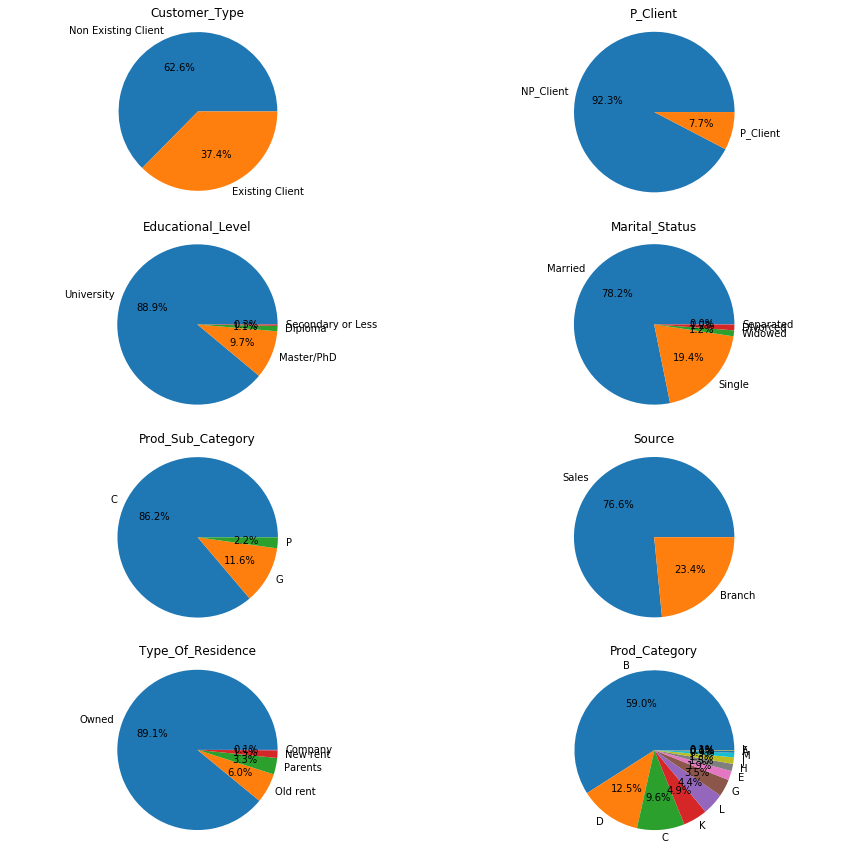

In [796]:
Categorical_Values = ['Customer_Type', 'P_Client', 'Educational_Level', 'Marital_Status','Prod_Sub_Category',
                     'Source', 'Type_Of_Residence', 'Prod_Category']

fig, axs = plt.subplots(4, 2, figsize=(15, 15))
for i in range(len(Categorical_Values)):
    cat = Categorical_Values[i]
    serie = data[cat].value_counts()
    labels = list(serie.index.values)
    sizes = list(serie.values)
    
    axs[i//2,i%2].pie(serie, labels = labels,autopct='%1.1f%%')
    axs[i//2,i%2].set_title(cat)
    axs[i//2,i%2].axis('equal')
    
plt.show()  

We also look at a description of everything we have in categorical variables (except dates) to see the distribution of what we have.

### 1.5.2. Label Encoding 

Pour certaines variables, on peut simplement faire du Label encoding, comme par exemple pour la première colonne : Customer_Type, ou on va considérer Existing Client = 0, non existing client = 1. Pour être plus efficace, on va effetctuer un label encoding pour toutes les variables categorielles qui ont seulement 2 categories.

In [797]:
le = LabelEncoder()
le.fit(data['Customer_Type'])

LabelEncoder()

In [798]:
list(le.classes_)

['Existing Client', 'Non Existing Client']

In [799]:
le.transform(data['Customer_Type']) 

array([1, 0, 1, ..., 1, 1, 1])

In [800]:
le = LabelEncoder()
le_count = 0

# Iterate through the columns
for col in data:
    if data[col].dtype == 'object':
        # If 2 or fewer unique categories
        if len(list(data[col].unique())) <= 2:
            # Train on the training data
            le.fit(data[col])
            # Transform both training and testing data
            data[col] = le.transform(data[col])
            
            
            # Keep track of how many columns were label encoded
            le_count += 1
            
print('%d columns were label encoded.' % le_count)

3 columns were label encoded.


### 1.5.3. One Hot Encoding 

Ici c'est simple, il existe une fonction pandas déjà écrite pour ca.

In [801]:
data = pd.get_dummies(data)

## 1.6. A last glance at our preprocessed dataset 

In [802]:
data.head()

,Y,Customer_Type,BirthDate,Customer_Open_Date,P_Client,Number_Of_Dependant,Years_At_Residence,Net_Annual_Income,Years_At_Business,Prod_Decision_Date,...,Prod_Category_D,Prod_Category_E,Prod_Category_F,Prod_Category_G,Prod_Category_H,Prod_Category_I,Prod_Category_J,Prod_Category_K,Prod_Category_L,Prod_Category_M
0,0,1,13299.0,295.0,0,3.0,1,36.0,1.0,294.0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,14420.0,1342.0,1,0.0,12,18.0,2.0,523.0,...,0,0,0,1,0,0,0,0,0,0
2,0,1,14757.0,275.0,0,2.0,10,36.0,1.0,244.0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,11443.0,467.0,0,3.0,3,36.0,1.0,514.0,...,0,0,0,0,0,0,0,0,1,0
4,0,1,22024.0,64.0,0,2.0,1,36.0,1.0,33.0,...,1,0,0,0,0,0,0,0,0,0


# 3. Data scale and split 

## 3.1. Split the data: train, validate, test

....

In [812]:
features_name = data.columns[1:]
y, X = data[['Y']].values[:,0], data[features_name].values

In [813]:
X_tmp, X_test, y_tmp, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_tmp, y_tmp, test_size=0.2, random_state=42)

In [814]:
np.mean(y_train), np.mean(y_val), np.mean(y_test)

(0.07319198373511472, 0.06736353077816493, 0.07713754646840149)

## 3.2. Fit the scaler on the train data

In [815]:
scaler = StandardScaler()
scaler.fit(X_train)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [816]:
X_train

array([[1.0000e+00, 1.2141e+04, 3.0700e+02, ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00],
       [1.0000e+00, 1.0044e+04, 5.6900e+02, ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00],
       [1.0000e+00, 2.0746e+04, 1.2200e+02, ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00],
       ...,
       [1.0000e+00, 1.0200e+04, 4.8700e+02, ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00],
       [1.0000e+00, 1.4859e+04, 2.2700e+02, ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00],
       [0.0000e+00, 1.8453e+04, 9.3400e+03, ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00]])

In [817]:
# transform train and validate 
X_train_s = scaler.transform(X_train)
X_val_s = scaler.transform(X_val)

# 4. Comparison of different models 

Let's fit a few models and compare the performance 

In [818]:
import xgboost as xgb

from sklearn.linear_model import LogisticRegression

## 4.1. Use a Logistic Regression

In [821]:
model1 = LogisticRegression()
model1.fit(X_train_s, y_train)

y_train_pred = model1.predict(X_train_s)
y_train_predprob = model1.predict_proba(X_train_s)[:,1]

y_val_pred = model1.predict(X_val_s)
y_val_predprob = model1.predict_proba(X_val_s)[:,1]

# Handle the global report of the model :

print("\n ---------------- Model Report ----------------")
print("\n --- TRAIN")
print("Accuracy :               {}".format(metrics.accuracy_score(y_train, y_train_pred)))
print("ROC AUC (Train):         {}".format(metrics.roc_auc_score(y_train, y_train_predprob)))
print("\n --- VALIDATE")
print("Accuracy :               {}".format(metrics.accuracy_score(y_val, y_val_pred)))
print("ROC AUC (Validate):      {}".format(metrics.roc_auc_score(y_val, y_val_predprob)))


 ---------------- Model Report ----------------

 --- TRAIN
Accuracy :               0.946267789718269
ROC AUC (Train):         0.9318793431924112

 --- VALIDATE
Accuracy :               0.9442508710801394
ROC AUC (Validate):      0.9198050414394298


## 4.3. Use XGBoost


 ---------------- Model Report ----------------

 --- TRAIN
Accuracy :               0.9575951205344176
ROC AUC (Train):         0.9645008530937706

 --- VALIDATE
Accuracy :               0.9547038327526133
ROC AUC (Validate):      0.9523339202129943



 			----------------------------- Feature Importances -----------------------------


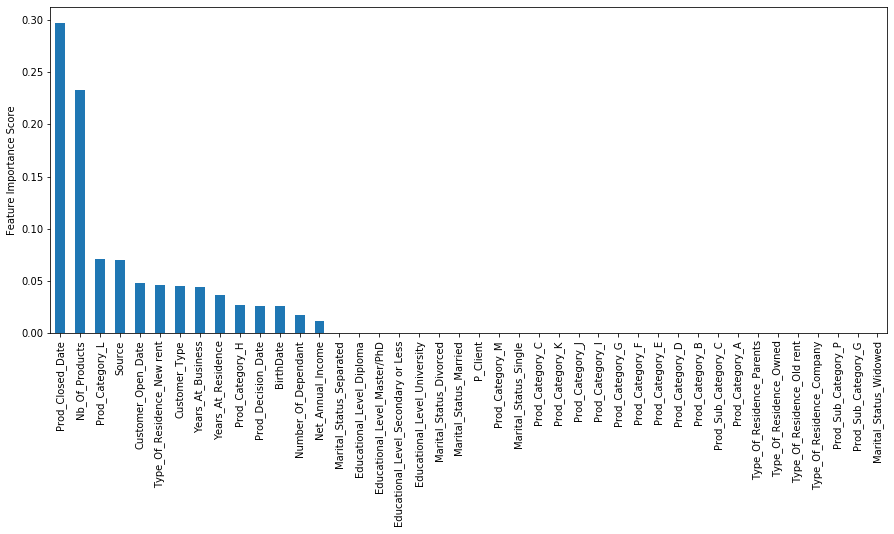

In [822]:
# use xgboost 
from sklearn.model_selection import GridSearchCV

model2 = xgb.XGBClassifier(n_estimators = 50)

model2.fit(X_train_s, y_train)

# Predict training and validation set:
y_train_pred = model2.predict(X_train_s)
y_train_predprob = model2.predict_proba(X_train_s)[:,1]

y_val_pred = model2.predict(X_val_s)
y_val_predprob = model2.predict_proba(X_val_s)[:,1]

# Handle the global report of the model :

print("\n ---------------- Model Report ----------------")
print("\n --- TRAIN")
print("Accuracy :               {}".format(metrics.accuracy_score(y_train, y_train_pred)))
print("ROC AUC (Train):         {}".format(metrics.roc_auc_score(y_train, y_train_predprob)))
print("\n --- VALIDATE")
print("Accuracy :               {}".format(metrics.accuracy_score(y_val, y_val_pred)))
print("ROC AUC (Validate):      {}".format(metrics.roc_auc_score(y_val, y_val_predprob)))

print("\n\n\n \t\t\t----------------------------- Feature Importances -----------------------------")

feat_imp = pd.Series(model2.feature_importances_, index=features_name).sort_values(ascending=False)
feat_imp.plot(kind='bar', figsize=(15, 6))
plt.ylabel('Feature Importance Score')
plt.show()

# 5. Tuning of the model 
XGBoost is known as a very consistent model. Many of its hyperparameters do not need a lot of tuning. Nevertheless, the number of estimators is the one that can have a big influence on the final performance of the model. Let's tune it. 

# 6. Conclusion 